In [1]:
from wobbles.workflow.compute_distribution_function import compute_df
from wobbles.workflow.integrate_single_orbit import integrate_orbit
from wobbles.potential_extension import PotentialExtension
from wobbles.disc import Disc

import numpy as np

import galpy
from galpy.potential import NFWPotential
from galpy.potential import MiyamotoNagaiPotential
from galpy.potential import PowerSphericalPotentialwCutoff
from galpy.potential import IsothermalDiskPotential
from galpy.util.bovy_conversion import dens_in_msolpc3

import astropy.units as apu
import matplotlib.pyplot as plt
import pickle

/Users/danielgilman/Code/external/galpy/galpy/util/bovy_conversion.py:6: FutureWarning: galpy.util.bovy_conversion is being deprecated in favor of galpy.util.conversion; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9
  warnings.warn('galpy.util.bovy_conversion is being deprecated in favor of galpy.util.conversion; all functions in there are the same; please switch to the new import, because the old import will be removed in v1.9',FutureWarning)

/Users/danielgilman/Code/external/galpy/galpy/util/bovy_plot.py:5: FutureWarning: galpy.util.bovy_plot is being deprecated in favor of galpy.util.plot; functions inside of this module have also changed name, but all functions still exist; please switch to the new import and new function names, because the old import and function names will be removed in v1.9
  warnings.warn('galpy.util.bovy_plot is being deprecated in favor of galpy.util.plot; functions inside of this module 

## Set up the orbit for the satellite

In [2]:
# Same as MilkyWayPotential14
norm0 = 0.35 # default is 0.35
galactic_potential = [PowerSphericalPotentialwCutoff(normalize=0.05,alpha=1.8,
                                                 rc=1.9/8.),
                      MiyamotoNagaiPotential(a=3./8.,b=0.28/8.,normalize=0.6),
                      NFWPotential(a=2.,normalize=norm0)]

t_orbit = -1.64 # Gyr
N_tsteps = 1500
time_Gyr = np.linspace(0., t_orbit, N_tsteps) * apu.Gyr 

orbit_init = [283. * apu.deg, -30. * apu.deg, 26. * apu.kpc,
        -2.6 * apu.mas/apu.yr, -1.3 * apu.mas/apu.yr, 140. * apu.km/apu.s] # Initial conditions of the satellite
satellite_orbit_physical_off = integrate_orbit(orbit_init, galactic_potential, time_Gyr)
satellite_orbit_list = [satellite_orbit_physical_off]

## Compute the action angle variabls for 3 different MW potentials

In [3]:
normalizations_local = [0.3]

z_min_max_kpc = 2.
vz_min_max_kmsec = 120
phase_space_N = 40
potential_local_list = []
for norm in normalizations_local:
    
    local_potential = [PowerSphericalPotentialwCutoff(normalize=0.05,alpha=1.8,
                                                 rc=1.9/8.),
                      MiyamotoNagaiPotential(a=3./8.,b=0.28/8.,normalize=0.6),
                      NFWPotential(a=2.,normalize=norm)]
    
    # PotentialExtension is a class that takes a "local" potential and does useful things with it specific 
    # to the problem at hand, like the vertical frequency of the disk, action angle coordinates, etc.
    potential_local = PotentialExtension(local_potential, z_min_max_kpc, vz_min_max_kmsec, phase_space_N)
    potential_local_list.append(potential_local)

## Set up the perturbing satellite potential, and compute the perturbed distribution functions

computing the force from 1 satellite orbits...
evaluating at r_ovver_r0 = 1.0
evaluating at vc_over_v0 = 0.9746794344808963
computed a midplane density of 0.1000423195779405 [Msun/pc^3]
local velocity dispersion (km/sec):  20.5
vertical frequency:  2.716352227183267


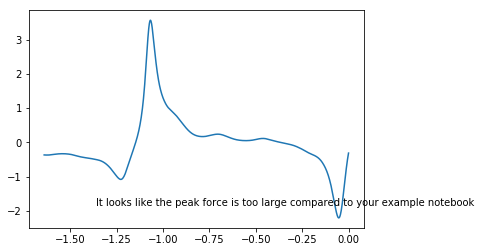

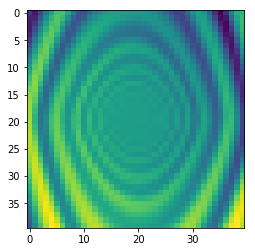

In [9]:
satellite_potential_1 = galpy.potential.HernquistPotential(amp=2.*1e10*apu.M_sun,a= 3.*apu.kpc) 
satellite_potential_2 = galpy.potential.HernquistPotential(amp=2.*0.2e9*apu.M_sun,a=0.65*apu.kpc) 
satellite_potential = satellite_potential_1 + satellite_potential_2
satellite_potential_list = [satellite_potential]
galpy.potential.turn_physical_off(satellite_potential)

dF_list = []
delta_J_list = []
force_list = []

# At some point we should probably switch to all times being specified in physical units
time_internal_units = satellite_orbit_list[0].time()

for pot_local in potential_local_list:
    
    disc = Disc(pot_local)
    
    dF, delta_J, force = compute_df(disc, time_internal_units,
                     satellite_orbit_list, satellite_potential_list, verbose=True)
    
    dF_list.append(dF)
    delta_J_list.append(delta_J)
    force_list.append(force)
    
fig = plt.figure(1)
ax = plt.gca()
# The force looks larger there than it did before, also the asymmetry looks a bit extreme
time_conversion = galpy.util.bovy_conversion.time_in_Gyr(220.,8.)
force_conversion = galpy.util.bovy_conversion.force_in_2piGmsolpc2(220.,8.)
ax.plot(time_internal_units*time_conversion, force_list[0][0,0]*force_conversion)
ax.annotate('It looks like the peak force is too large compared to your example notebook', xy=(0.2, 0.1), xycoords='axes fraction')
fig = plt.figure(2)
plt.imshow(delta_J_list[0])

Text(0.3,0.1,'This looks extreme... ')

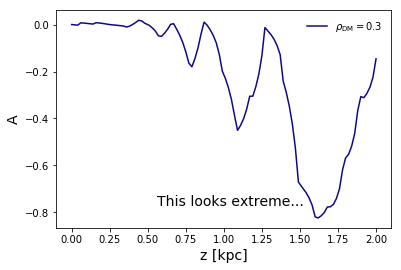

In [5]:
from matplotlib import cm

L = len(dF_list)
labels = [str(np.round(norm, 2)) for norm in normalizations_local]
colors = [cm.plasma(i/L) for i in range(0, len(dF_list))]

fig = plt.figure(1)
ax = plt.gca()
label_0 = r'$\rho_{\rm{DM}}=$'

n_points = len(dF_list[0].A)
z_plot = np.round(np.linspace(0, dF_list[0].z[-1], n_points), 2)

for i in range(0, len(normalizations_local)):
    plt.plot(z_plot, dF_list[i].A, color=colors[i], label=label_0+labels[i])
plt.legend(frameon=False)
ax.set_xlabel('z [kpc]', fontsize=14)
ax.set_ylabel('A', fontsize=14)
ax.annotate('This looks extreme... ', xy=(0.3, 0.1), xycoords='axes fraction', fontsize=14)

Text(0,0.5,'$v_z \\left[\\rm{kpc}\\right]$')

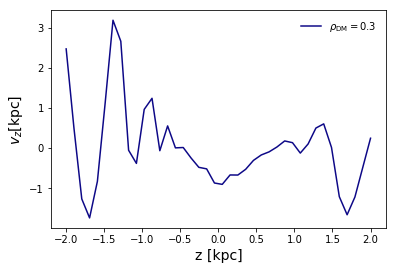

In [6]:
fig = plt.figure(1)
ax = plt.gca()
for i in range(0, len(normalizations_local)):
    plt.plot(dF_list[0].z, dF_list[i].mean_v_relative, color=colors[i], label=label_0+labels[i])
plt.legend(frameon=False)
ax.set_xlabel('z [kpc]', fontsize=14)
ax.set_ylabel(r'$v_z \left[\rm{kpc}\right]$', fontsize=14)
#plt.savefig('isothermal_vz.pdf')

Text(0,0.5,'$\\sigma_{v_z} \\ \\left[\\rm{kpc \\ \\rm{s^{-1}}}\\right]$')

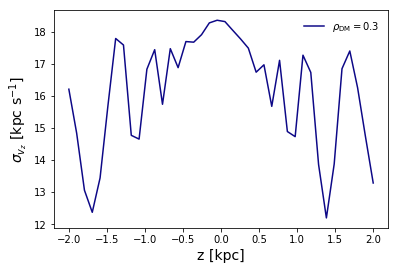

In [7]:
fig = plt.figure(1)
ax = plt.gca()
for i in range(0, len(normalizations_local)):
    plt.plot(dF_list[0].z, dF_list[i].velocity_dispersion, color=colors[i], label=label_0+labels[i])
plt.legend(frameon=False)
ax.set_xlabel('z [kpc]', fontsize=14)
ax.set_ylabel(r'$\sigma_{v_z} \ \left[\rm{kpc \ \rm{s^{-1}}}\right]$', fontsize=14)
#plt.savefig('isothermal_vz.pdf')